# Data exploration

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time
import gc
from scipy.stats import binom
from scipy.special import comb

In [2]:
# Mount drive on Google Colab
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/privacy'
%ls -l
print(os.listdir())

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/privacy
total 3735913
-rw------- 1 root root        450 Feb 21 18:43 clean_data.py
-rw------- 1 root root      14242 Mar 26 18:21 date_similarity.png
-rw------- 1 root root      16495 Mar  7 21:26 exp_0.txt
-rw------- 1 root root      23321 Mar  8 01:26 exp_1.txt
-rw------- 1 root root      17778 Mar  8 17:12 exp_3.txt
-rw------- 1 root root      15170 Mar  8 19:23 exp_4.txt
-rw------- 1 root root          0 Mar

In [0]:
%load_ext autoreload
%autoreload 1

%aimport privacy

In [4]:
# TO LOAD DATA FROM COLAB
# df = pd.read_csv('netflix.ratings.csv', nrows = 100000, index_col = 1, dtype={'movieId':np.int16, 'custId':np.int32, 'rating':np.int8, 'date':'object'})
# df = pd.read_csv('netflix.ratings.csv', index_col = 1, dtype={'movieId':np.int16, 'custId':np.int32, 'rating':np.int8, 'date':'object'}, na_filter=False)
# iter_csv = pd.read_csv('netflix.ratings.csv', iterator=True, chunksize=1000)
# df = pd.concat([chunk[chunk['field'] > constant] for chunk in iter_csv]

# TO LOAD DATA FROM THE REPO DIRECTORY (in datasets/), USE THE FOLLOWING
df = pd.read_csv('datasets/netflix.ratings.csv', index_col = 1, dtype={'movieId':np.int16, 'custId':np.int32, 'rating':np.int8, 'date':'object'}, na_filter=False)


print('data usage : {} GB'.format(df.memory_usage().sum()/1024**3))

MIN_DATE = '1999-11-11'
MAX_DATE = '2005-12-31'
print((pd.to_datetime(MAX_DATE) - pd.to_datetime(MIN_DATE)).days)

df['days'] = ((pd.to_datetime(df['date']) - pd.to_datetime(MIN_DATE)).dt.days).astype(np.int16)
df = df.drop('date', axis=1)
# df.index = df.index.astype(np.int32)
print('data usage : {} GB'.format(df.memory_usage().sum()/1024**3))
df.head()

data usage : 1.7780155250802636 GB
2242
data usage : 1.216536938212812 GB


,movieId,rating,days
custId,,,
1488844,1,3,2126
822109,1,5,2010
885013,1,4,2169
30878,1,4,2237
823519,1,3,1635


## Histograms

Distribution of mean, standard deviation, count metrics for ratings and ratings days of  customers.

In [0]:
custdata = df.reset_index().groupby('custId').agg({'rating':['mean','std','count'], 'days':['mean','std','count']})

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


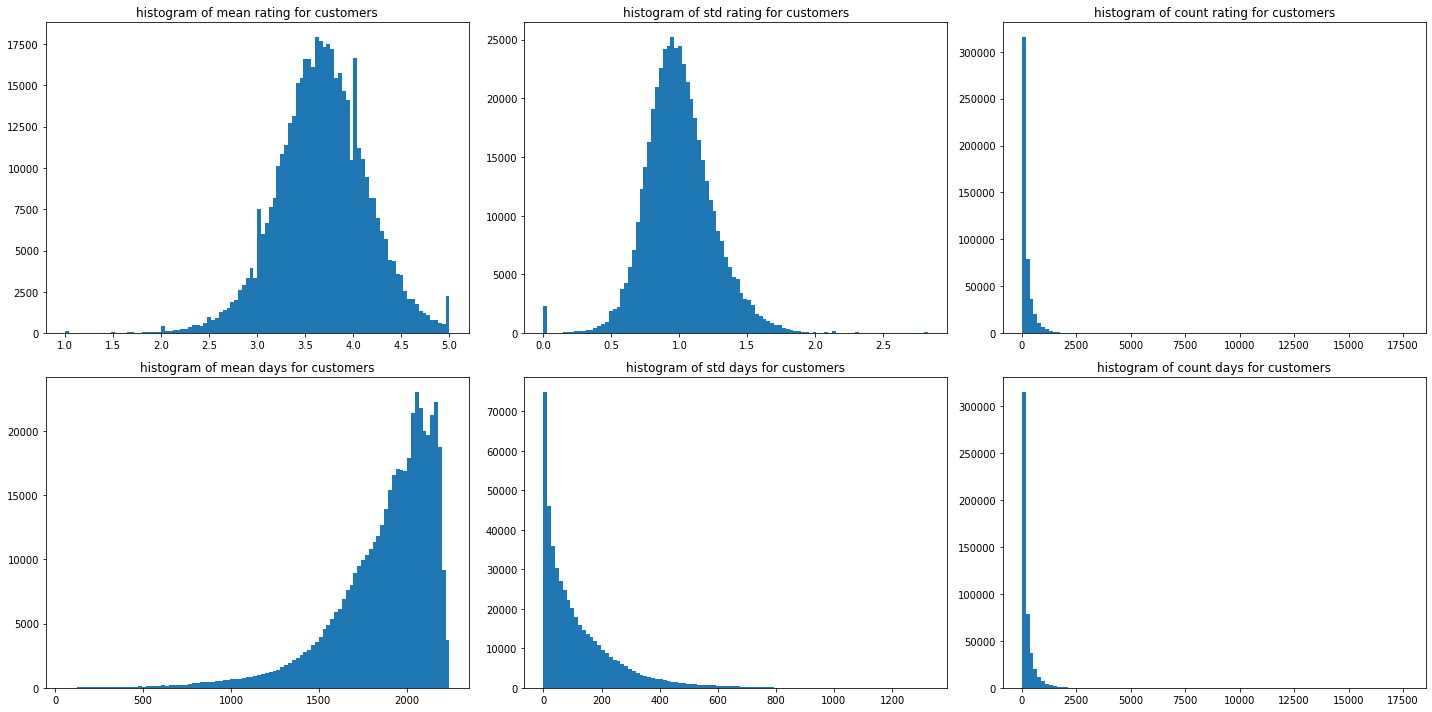

In [0]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i, variable in enumerate(['rating', 'days']):
  for j, metric in enumerate(['mean', 'std', 'count']):
    ax[i,j].hist(custdata[(variable, metric)], bins=100)
    ax[i,j].set_title('histogram of {} {} for customers'.format(metric, variable))

plt.tight_layout()
plt.savefig('histograms_customer_data.png')
plt.show()

In [0]:
moviedata = df.reset_index().groupby('movieId').agg({'rating':['mean','std','count'], 'days':['mean','std','count']})

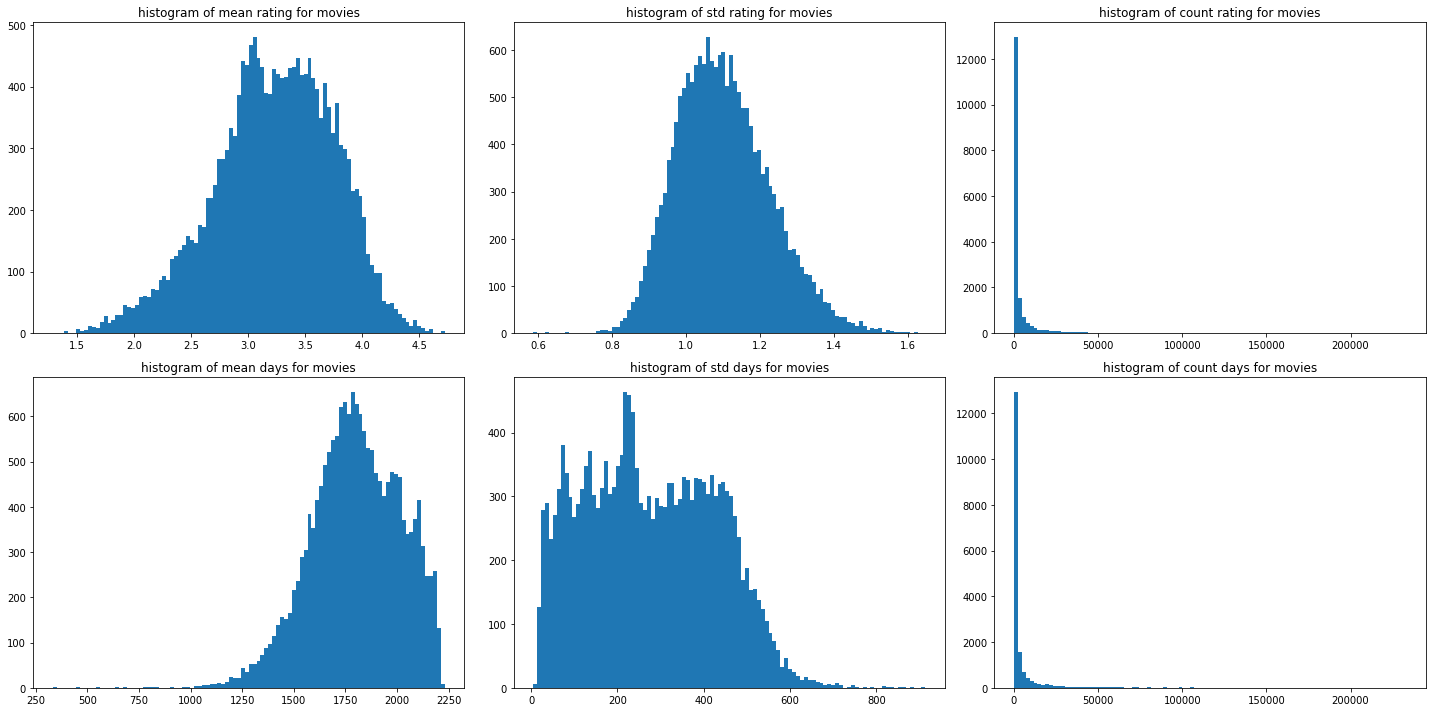

In [0]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i, variable in enumerate(['rating', 'days']):
  for j, metric in enumerate(['mean', 'std', 'count']):
    ax[i,j].hist(moviedata[(variable, metric)], bins=100)
    ax[i,j].set_title('histogram of {} {} for movies'.format(metric, variable))

plt.tight_layout()
plt.savefig('histograms_movie_data.png')
plt.show()

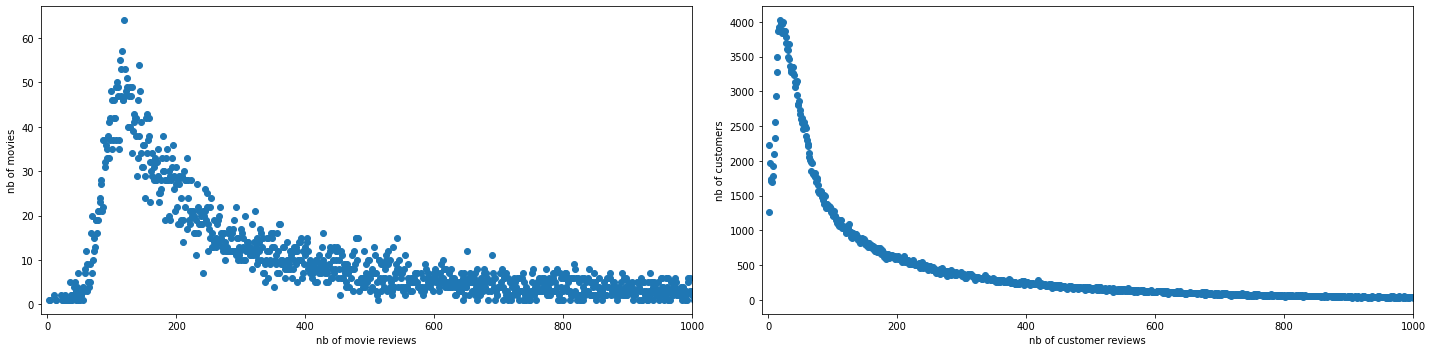

In [0]:
nb_movie_reviews = moviedata[('rating', 'count')].value_counts().sort_index()
nb_cust_reviews = custdata[('rating', 'count')].value_counts().sort_index()

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].scatter(nb_movie_reviews.index, nb_movie_reviews)
ax[0].set_xlim(-10,1000)
ax[0].set_xlabel('nb of movie reviews')
ax[0].set_ylabel('nb of movies')

ax[1].scatter(nb_cust_reviews.index, nb_cust_reviews)
ax[1].set_xlim(-10,1000)
ax[1].set_xlabel('nb of customer reviews')
ax[1].set_ylabel('nb of customers')

plt.tight_layout()
plt.savefig('nb_reviews.png')
plt.show()

In [0]:
nb_cust_reviews = custdata[('rating', 'count')].value_counts().sort_index()

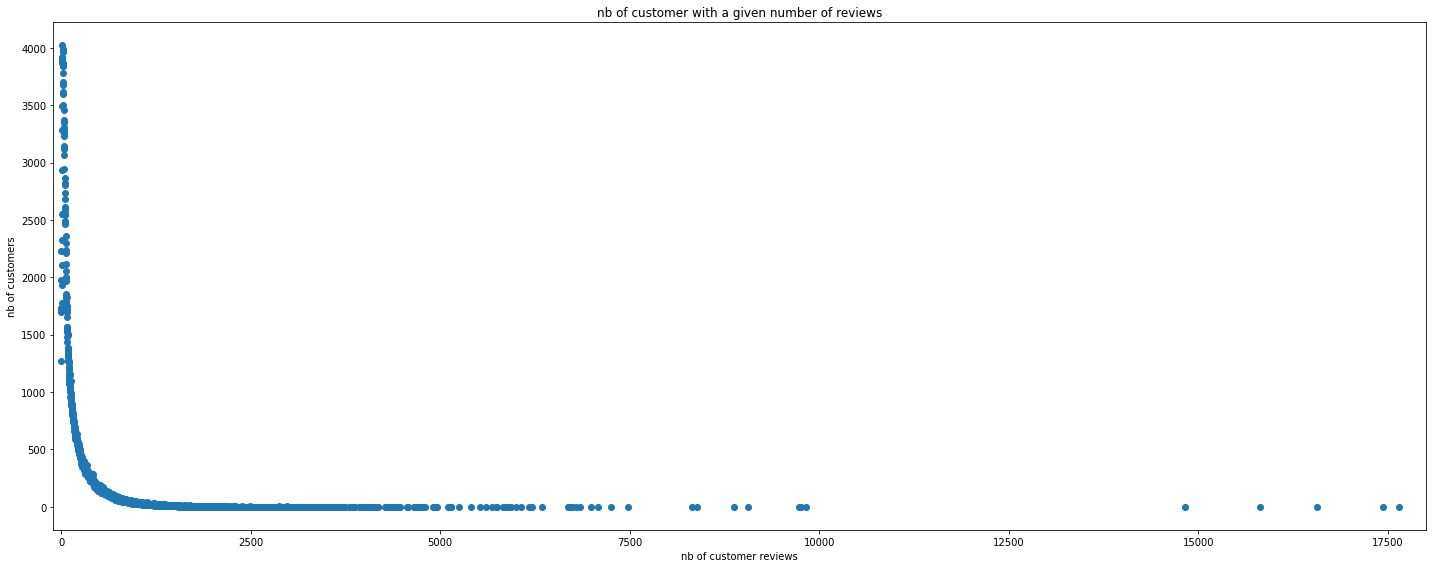

nb of customers with more than 5000 reviews: 43


In [76]:
fig, ax = plt.subplots(1, figsize=(20,8))

ax.scatter(nb_cust_reviews.index, nb_cust_reviews)

ax.set_xlim(-100,18000)
ax.set_xlabel('nb of customer reviews')
ax.set_ylabel('nb of customers')
ax.set_title('nb of customer with a given number of reviews')

plt.tight_layout()
plt.savefig('nb_reviews_details.png')
plt.show()

print('nb of customers with more than 5000 reviews: {}'.format(nb_cust_reviews.loc[nb_cust_reviews.index>=5000].sum()))

# Orders of magnitude

In [0]:
print("nb of movies: {}".format(len(moviedata)))
print("nb of customers: {}".format(len(custdata)))

print("total nb of records: {}".format(len(df)))

print("avg nb of reviews per movie: {}".format(round(len(df)/len(moviedata),2)))
print("avg nb of reviews per customer: {}".format(round(len(df)/len(custdata),2)))

print('max nb of reviews for a movie: {}'.format(moviedata[('rating', 'count')].max()))
print('max nb of reviews for a customer: {}'.format(custdata[('rating', 'count')].max()))

nb of movies: 17770
nb of customers: 480189
total nb of records: 100480507
avg nb of reviews per movie: 5654.5
avg nb of reviews per customer: 209.25
max nb of reviews for a movie: 232944
max nb of reviews for a customer: 17653


In [0]:
# Penalties and similarity function

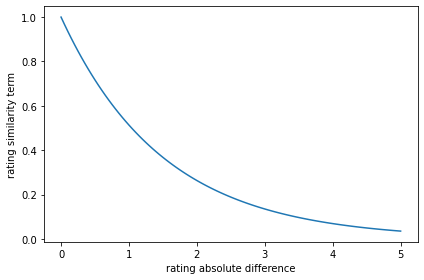

In [0]:
x = np.linspace(0,5,101)
plt.plot(x, np.exp(-x/1.5))
plt.xlabel('rating absolute difference')
plt.ylabel('rating similarity term')

plt.tight_layout()
plt.savefig('rating_similarity.png')
plt.show()

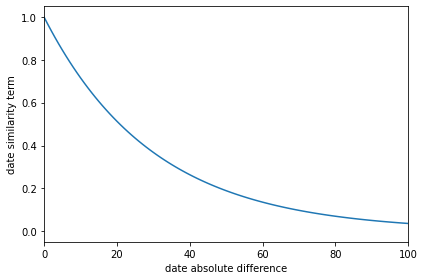

In [0]:
x = np.linspace(0,2242,2243)
plt.plot(x, np.exp(-x/30))
plt.xlim(0,100)
plt.xlabel('date absolute difference')
plt.ylabel('date similarity term')

plt.tight_layout()
plt.savefig('date_similarity.png')
plt.show()

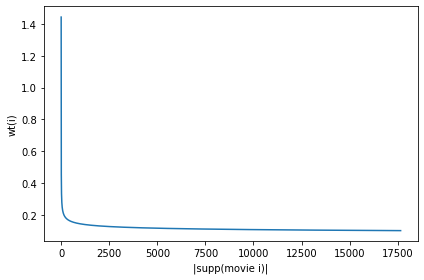

In [0]:
x = np.linspace(2,17653,17653-2+1)
plt.plot(x, 1/np.log(x))
# plt.xlim(0,100)
plt.xlabel('|supp(movie i)|')
plt.ylabel('wt(i)')

plt.tight_layout()
plt.savefig('wt_coef.png')
plt.show()

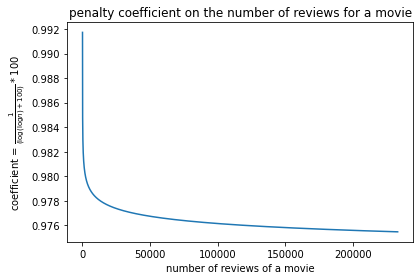

In [0]:
n = np.linspace(10, 232944, 232944-10+1)
plt.plot(n, 1/(np.log(np.log(n))+100)*100)

plt.xlabel('number of reviews of a movie')
plt.ylabel(r'coefficient = $\frac{1}{(\log{(\log{n})}+100)}*100$')
plt.title('penalty coefficient on the number of reviews for a movie')

plt.tight_layout()
plt.savefig('loglog_coef.png')
plt.show()

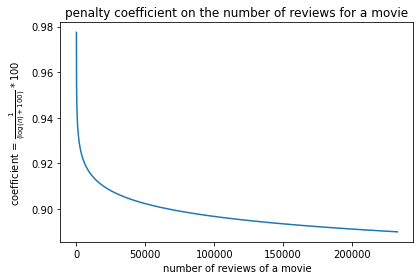

In [0]:
n = np.linspace(10, 232944, 232944-10+1)
plt.plot(n, 1/(np.log(n)+100)*100)

plt.xlabel('number of reviews of a movie')
plt.ylabel(r'coefficient = $\frac{1}{(\log{(n)}+100)}*100$')
plt.title('penalty coefficient on the number of reviews for a movie')

plt.tight_layout()
plt.savefig('log_coef.png')
plt.show()

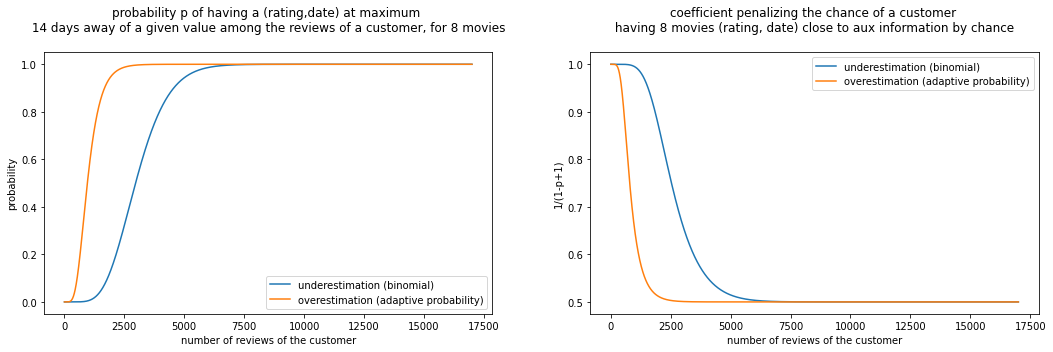

In [45]:
p = 29/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 8

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax[0].plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax[0].set_xlabel('number of reviews of the customer')
ax[0].set_ylabel('probability')
ax[0].set_title('probability p of having a (rating,date) at maximum \n 14 days away of a given value among the reviews of a customer, for {} movies \n'.format(s))
ax[0].legend()

ax[1].plot(n, 1/(1-binom.cdf(s-1, n, p)+1), label='underestimation (binomial)')
ax[1].plot(n, 1/(sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)])+1), label='overestimation (adaptive probability)')
ax[1].set_xlabel('number of reviews of the customer')
ax[1].set_ylabel('1/(1-p+1)')
ax[1].set_title('coefficient penalizing the chance of a customer \n having {} movies (rating, date) close to aux information by chance \n'.format(s))
ax[1].legend()

plt.tight_layout()
plt.savefig('probabilities_14.png')
plt.show()

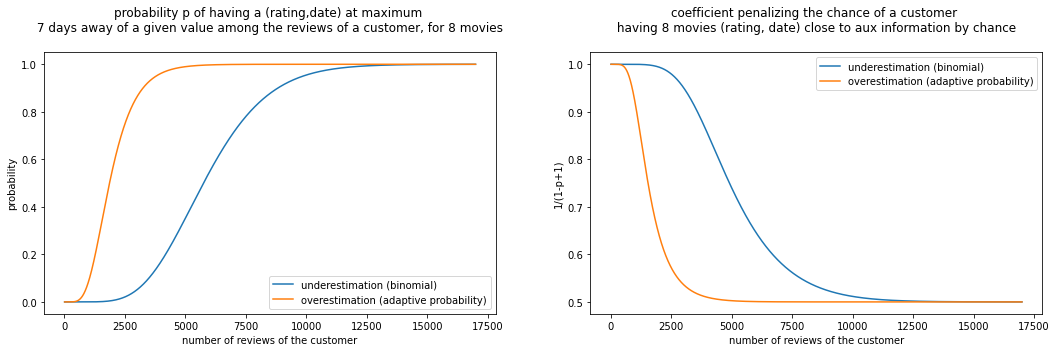

In [46]:
p = 15/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 8

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax[0].plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax[0].set_xlabel('number of reviews of the customer')
ax[0].set_ylabel('probability')
ax[0].set_title('probability p of having a (rating,date) at maximum \n 7 days away of a given value among the reviews of a customer, for {} movies \n'.format(s))
ax[0].legend()

ax[1].plot(n, 1/(1-binom.cdf(s-1, n, p)+1), label='underestimation (binomial)')
ax[1].plot(n, 1/(sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)])+1), label='overestimation (adaptive probability)')
ax[1].set_xlabel('number of reviews of the customer')
ax[1].set_ylabel('1/(1-p+1)')
ax[1].set_title('coefficient penalizing the chance of a customer \n having {} movies (rating, date) close to aux information by chance \n'.format(s))
ax[1].legend()

plt.tight_layout()
plt.savefig('probabilities_7.png')
plt.show()

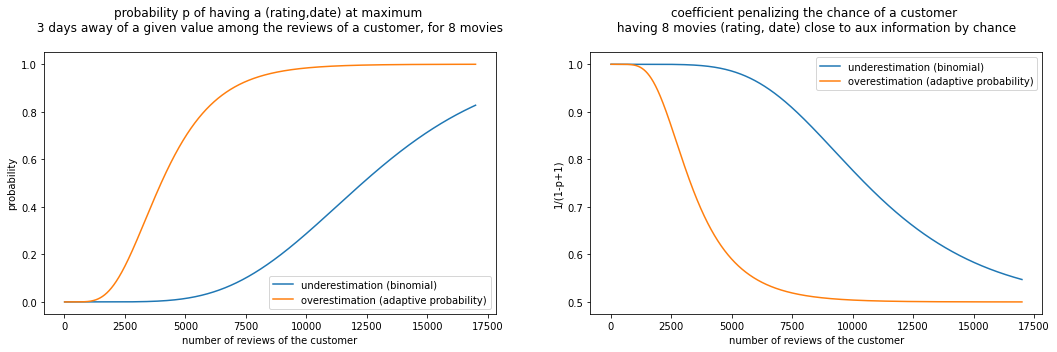

In [47]:
p = 7/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 8

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax[0].plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax[0].set_xlabel('number of reviews of the customer')
ax[0].set_ylabel('probability')
ax[0].set_title('probability p of having a (rating,date) at maximum \n 3 days away of a given value among the reviews of a customer, for {} movies \n'.format(s))
ax[0].legend()

ax[1].plot(n, 1/(1-binom.cdf(s-1, n, p)+1), label='underestimation (binomial)')
ax[1].plot(n, 1/(sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)])+1), label='overestimation (adaptive probability)')
ax[1].set_xlabel('number of reviews of the customer')
ax[1].set_ylabel('1/(1-p+1)')
ax[1].set_title('coefficient penalizing the chance of a customer \n having {} movies (rating, date) close to aux information by chance \n'.format(s))
ax[1].legend()

plt.tight_layout()
plt.savefig('probabilities_3.png')
plt.show()

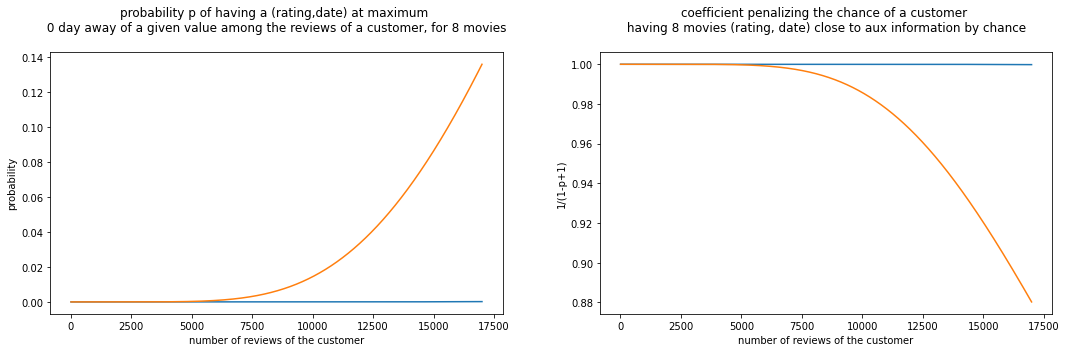

In [48]:
p = 1/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 8

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax[0].plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax[0].set_xlabel('number of reviews of the customer')
ax[0].set_ylabel('probability')
ax[0].set_title('probability p of having a (rating,date) at maximum \n 0 day away of a given value among the reviews of a customer, for {} movies \n'.format(s))

ax[1].plot(n, 1/(1-binom.cdf(s-1, n, p)+1), label='underestimation (binomial)')
ax[1].plot(n, 1/(sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)])+1), label='overestimation (adaptive probability)')
ax[1].set_xlabel('number of reviews of the customer')
ax[1].set_ylabel('1/(1-p+1)')
ax[1].set_title('coefficient penalizing the chance of a customer \n having {} movies (rating, date) close to aux information by chance \n'.format(s))

plt.tight_layout()
plt.savefig('probabilities_0.png')
plt.show()

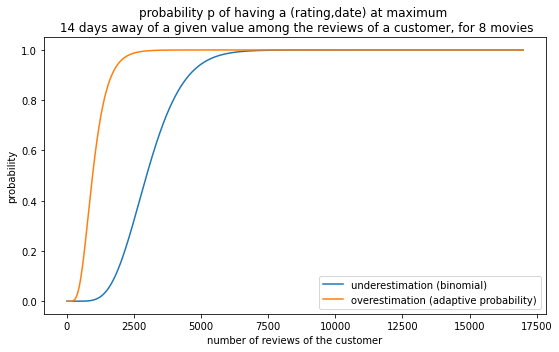

In [49]:
p = 29/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 8

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax.plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax.set_xlabel('number of reviews of the customer')
ax.set_ylabel('probability')
ax.set_title('probability p of having a (rating,date) at maximum \n 14 days away of a given value among the reviews of a customer, for {} movies'.format(s))

plt.legend()
plt.tight_layout()
plt.savefig('probabilities_14_alone.png')
plt.show()

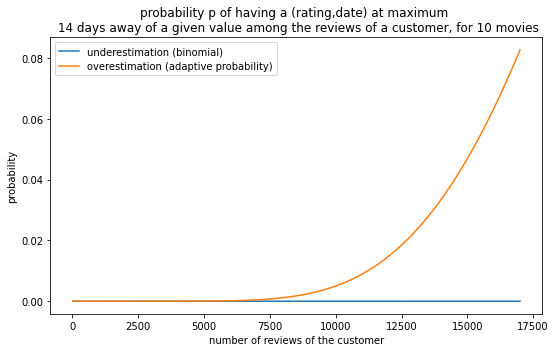

In [50]:
p = 1/11250
n = np.linspace(10, 17000, 17000-10+1)
s = 10

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax.plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax.set_xlabel('number of reviews of the customer')
ax.set_ylabel('probability')
ax.set_title('probability p of having a (rating,date) at maximum \n 14 days away of a given value among the reviews of a customer, for {} movies'.format(s))

plt.legend()
plt.tight_layout()
plt.savefig('probabilities_0_alone.png')
plt.show()

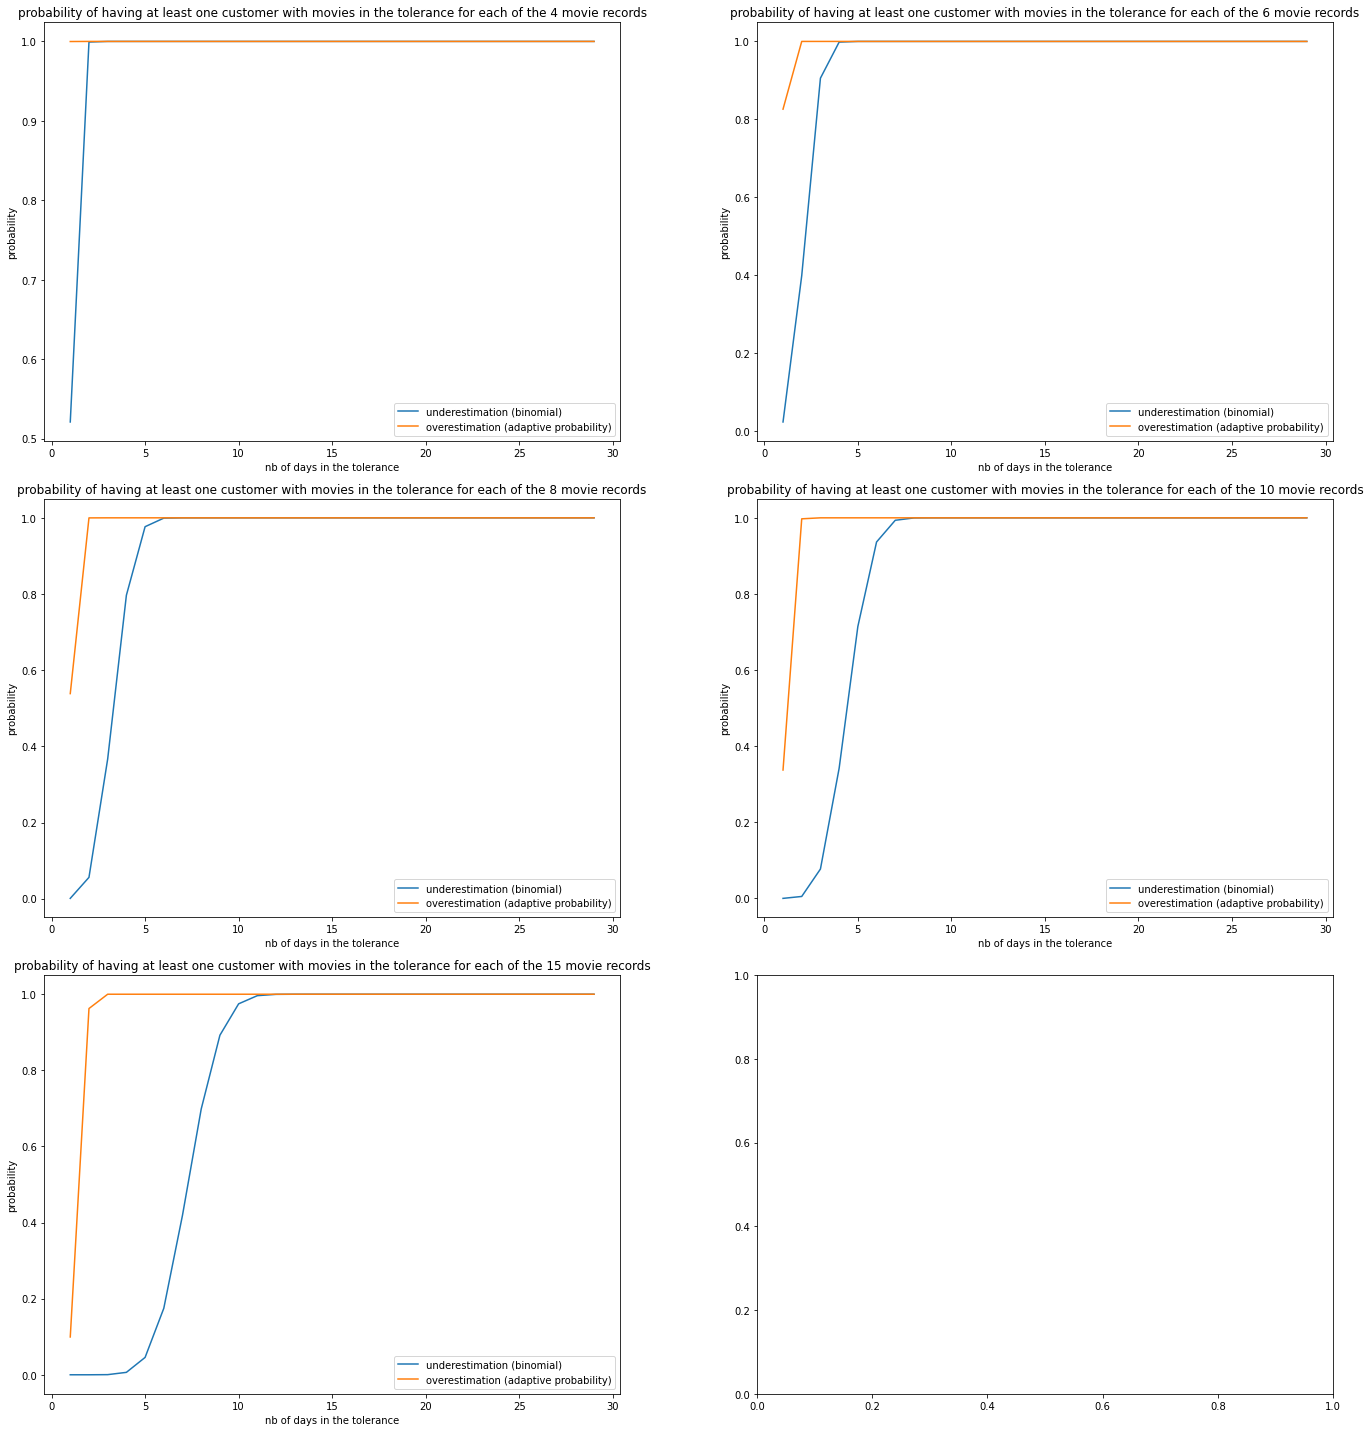

In [51]:
nb_days = np.arange(1, 29+1)
p = nb_days/11250
aux_size = [4,6,8,10,15]

ncols = 2
nrows = len(aux_size)//ncols + (len(aux_size)%ncols!=0)

fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))

for k, s in enumerate(aux_size):
  i,j = k//ncols, k%ncols

  probas = nb_cust_reviews.to_frame(name='count').reset_index()
  probas['indiv_proba'] = probas['index'].apply(lambda n: binom.cdf(s-1, n, p))
  probas['collect_proba'] = probas['indiv_proba']**probas['count']

  probas['indiv_proba_2'] = probas['index'].apply(lambda n: 1-sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]))
  probas['collect_proba_2'] = probas['indiv_proba_2']**probas['count']

  ax[i,j].plot(nb_days, 1-probas['collect_proba'].prod(), label='underestimation (binomial)')
  ax[i,j].plot(nb_days, 1-probas['collect_proba_2'].prod(), label='overestimation (adaptive probability)')
  ax[i,j].set_xlabel('nb of days in the tolerance')
  ax[i,j].set_ylabel('probability')
  ax[i,j].set_title('probability of having at least one customer with movies in the tolerance for each of the {} movie records'.format(s))
  ax[i,j].legend()

plt.tight_layout()
plt.savefig('probabilities_whole_dataset.png')
plt.show()

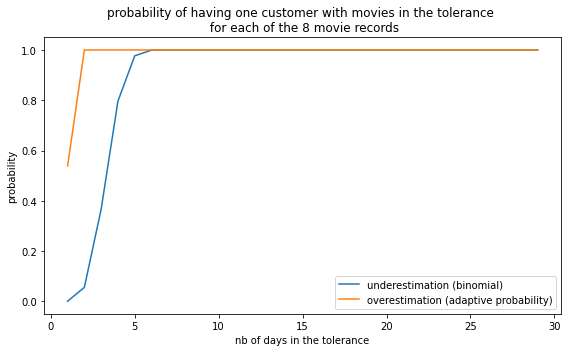

In [52]:
nb_days = np.arange(1, 29+1)
p = nb_days/11250
s = 8

probas = nb_cust_reviews.to_frame(name='count').reset_index()
probas['indiv_proba'] = probas['index'].apply(lambda n: binom.cdf(s-1, n, p))
probas['collect_proba'] = probas['indiv_proba']**probas['count']

probas['indiv_proba_2'] = probas['index'].apply(lambda n: 1-sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]))
probas['collect_proba_2'] = probas['indiv_proba_2']**probas['count']

  

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(nb_days, 1-probas['collect_proba'].prod(), label='underestimation (binomial)')
ax.plot(nb_days, 1-probas['collect_proba_2'].prod(), label='overestimation (adaptive probability)')
ax.set_xlabel('nb of days in the tolerance')
ax.set_ylabel('probability')
ax.set_title('probability of having one customer with movies in the tolerance \n for each of the {} movie records'.format(s))
ax.legend()

plt.tight_layout()
plt.savefig('probabilities_whole_dataset_8_movies.png')
plt.show()

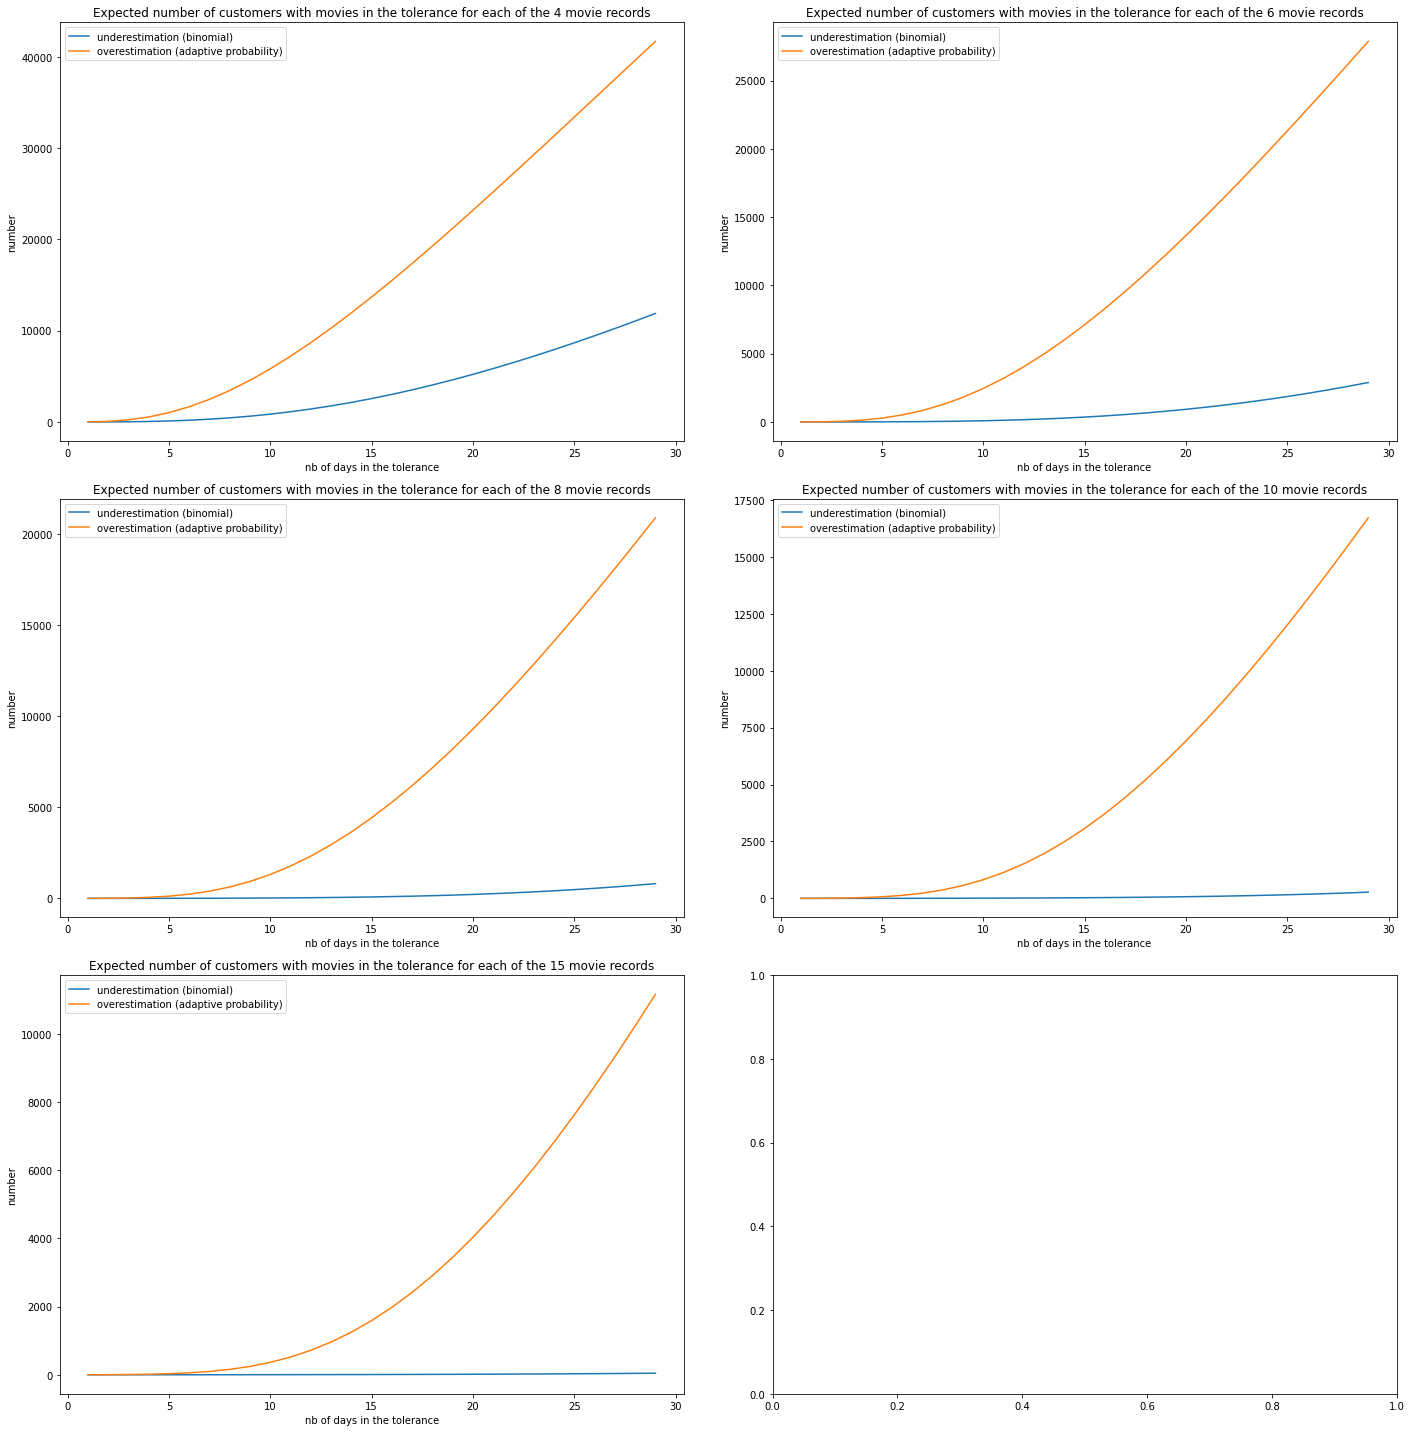

In [66]:
nb_days = np.arange(1, 29+1)
p = nb_days/11250
aux_size = [4,6,8,10,15]

ncols = 2
nrows = len(aux_size)//ncols + (len(aux_size)%ncols!=0)

fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))

for k, s in enumerate(aux_size):
  i,j = k//ncols, k%ncols

  probas = nb_cust_reviews.to_frame(name='count').reset_index()
  probas['indiv_proba'] = probas['index'].apply(lambda n: 1-binom.cdf(s-1, n, p))
  probas['expected_num'] = probas['indiv_proba']*probas['count']

  probas['indiv_proba_2'] = probas['index'].apply(lambda n: sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]))
  probas['expected_num_2'] = probas['indiv_proba_2']*probas['count']

  ax[i,j].plot(nb_days, probas['expected_num'].sum(), label='underestimation (binomial)')
  ax[i,j].plot(nb_days, probas['expected_num_2'].sum(), label='overestimation (adaptive probability)')
  ax[i,j].set_xlabel('nb of days in the tolerance')
  ax[i,j].set_ylabel('number')
  ax[i,j].set_title('Expected number of customers with movies in the tolerance for each of the {} movie records'.format(s))
  ax[i,j].legend()

plt.tight_layout()
plt.savefig('expectation_whole_dataset.png')
plt.show()

### with the movie information

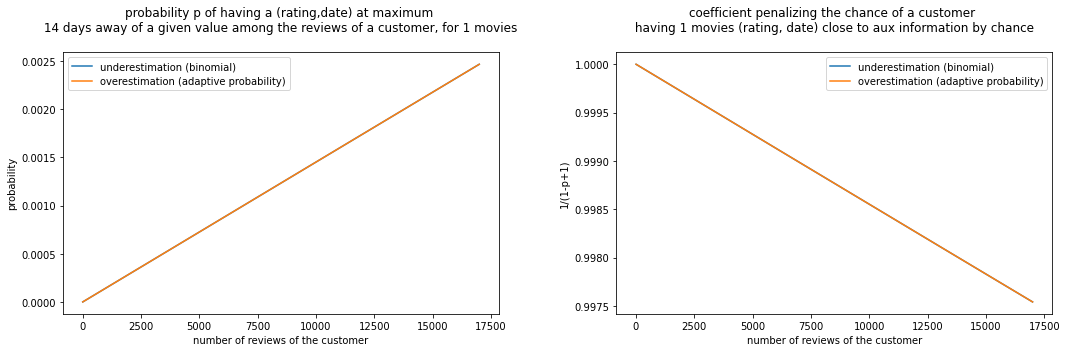

In [57]:
p = 29/(11250*17770)
n = np.linspace(10, 17000, 17000-10+1)
s = 1

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(n, 1-binom.cdf(s-1, n, p), label='underestimation (binomial)')
ax[0].plot(n, sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]), label='overestimation (adaptive probability)')
ax[0].set_xlabel('number of reviews of the customer')
ax[0].set_ylabel('probability')
ax[0].set_title('probability p of having a (rating,date) at maximum \n 14 days away of a given value among the reviews of a customer, for {} movies \n'.format(s))
ax[0].legend()

ax[1].plot(n, 1/(1-binom.cdf(s-1, n, p)+1), label='underestimation (binomial)')
ax[1].plot(n, 1/(sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)])+1), label='overestimation (adaptive probability)')
ax[1].set_xlabel('number of reviews of the customer')
ax[1].set_ylabel('1/(1-p+1)')
ax[1].set_title('coefficient penalizing the chance of a customer \n having {} movies (rating, date) close to aux information by chance \n'.format(s))
ax[1].legend()

plt.tight_layout()
plt.savefig('probabilities_14_withmovies.png')
plt.show()

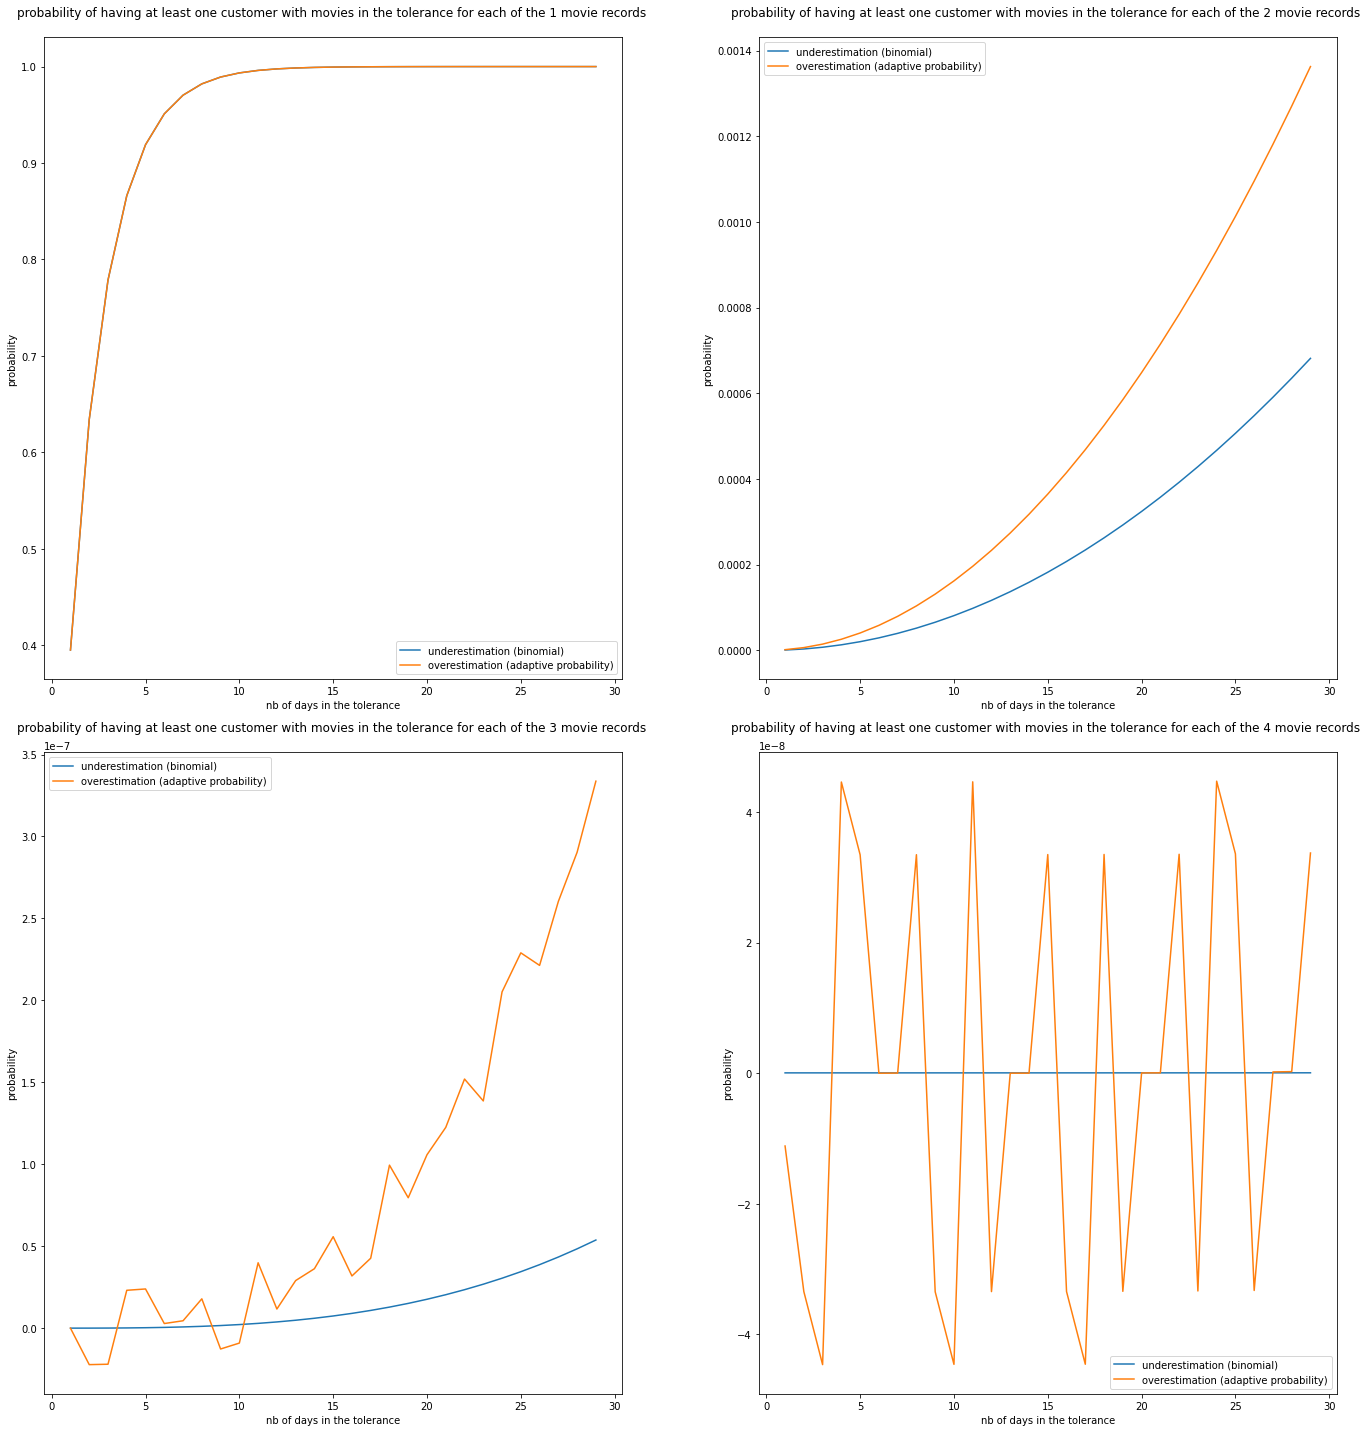

In [58]:
nb_days = np.arange(1, 29+1)
p = nb_days/(11250*17770)
aux_size = [1,2,3,4]

ncols = 2
nrows = len(aux_size)//ncols + (len(aux_size)%ncols!=0)

fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))

for k, s in enumerate(aux_size):
  i,j = k//ncols, k%ncols

  probas = nb_cust_reviews.to_frame(name='count').reset_index()
  probas['indiv_proba'] = probas['index'].apply(lambda n: binom.cdf(s-1, n, p))
  probas['collect_proba'] = probas['indiv_proba']**probas['count']

  probas['indiv_proba_2'] = probas['index'].apply(lambda n: 1-sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]))
  probas['collect_proba_2'] = probas['indiv_proba_2']**probas['count']

  ax[i,j].plot(nb_days, 1-probas['collect_proba'].prod(), label='underestimation (binomial)')
  ax[i,j].plot(nb_days, 1-probas['collect_proba_2'].prod(), label='overestimation (adaptive probability)')
  ax[i,j].set_xlabel('nb of days in the tolerance')
  ax[i,j].set_ylabel('probability')
  ax[i,j].set_title('probability of having at least one customer with movies in the tolerance for each of the {} movie records \n'.format(s))
  ax[i,j].legend()

plt.tight_layout()
plt.savefig('probabilities_whole_dataset_withmovies.png')
plt.show()

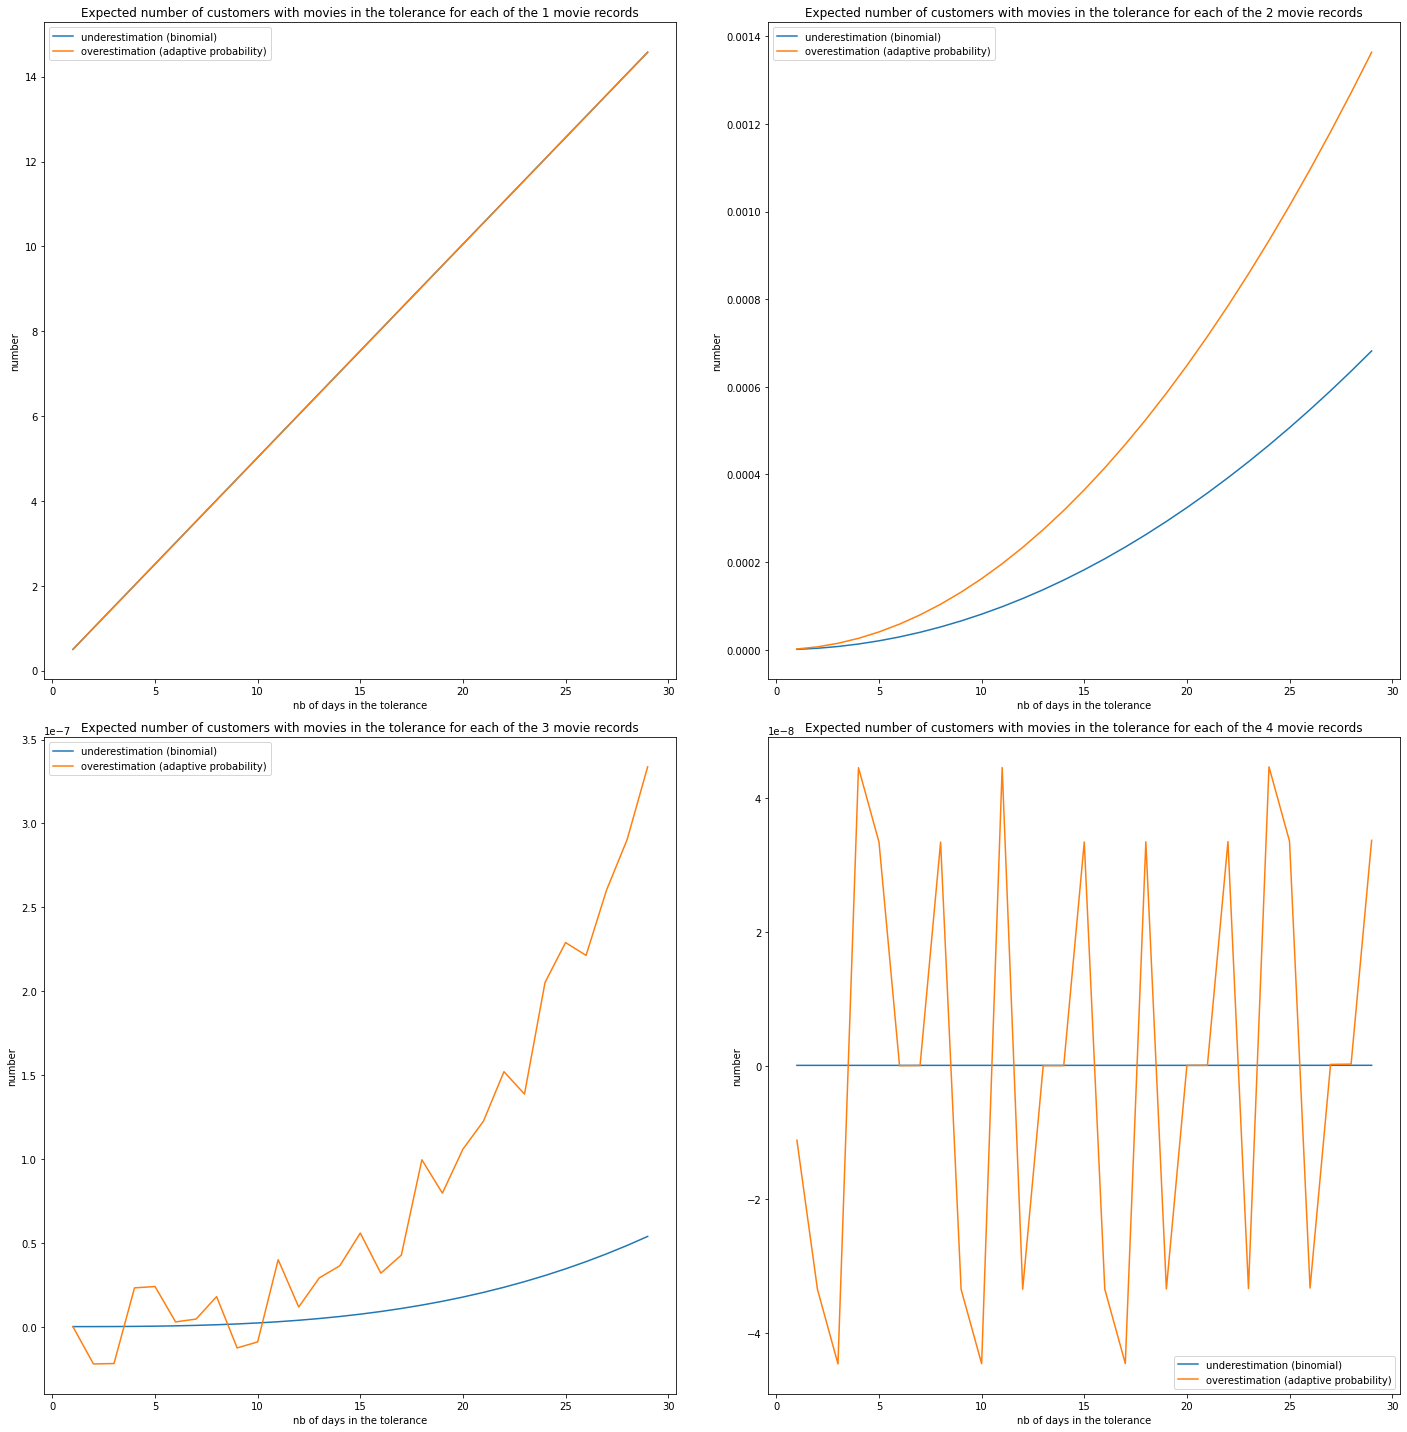

In [72]:
nb_days = np.arange(1, 29+1)
p = nb_days/(11250*17770)
aux_size = [1,2,3,4]

ncols = 2
nrows = len(aux_size)//ncols + (len(aux_size)%ncols!=0)

fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))

for k, s in enumerate(aux_size):
  i,j = k//ncols, k%ncols

  probas = nb_cust_reviews.to_frame(name='count').reset_index()
  probas['indiv_proba'] = probas['index'].apply(lambda n: 1-binom.cdf(s-1, n, p))
  probas['expected_num'] = probas['indiv_proba']*probas['count']

  probas['indiv_proba_2'] = probas['index'].apply(lambda n: sum([comb(s,k)*(1-k*p)**n*(-1)**k for k in range(s+1)]))
  probas['expected_num_2'] = probas['indiv_proba_2']*probas['count']

  ax[i,j].plot(nb_days, probas['expected_num'].sum(), label='underestimation (binomial)')
  ax[i,j].plot(nb_days, probas['expected_num_2'].sum(), label='overestimation (adaptive probability)')
  ax[i,j].set_xlabel('nb of days in the tolerance')
  ax[i,j].set_ylabel('number')
  ax[i,j].set_title('Expected number of customers with movies in the tolerance for each of the {} movie records'.format(s))
  ax[i,j].legend()

plt.tight_layout()
plt.savefig('expectation_whole_dataset_withmovies.png')
plt.show()